# Betting visualization and search for similar games
### Denisov Ilia

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
%pylab inline
from datetime import datetime
from collections import Counter
import matplotlib.mlab as mlab
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
np.set_printoptions(precision=2, threshold=5)
import scipy as sp
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


## Preparing a dataset
Using Hamid Sardar's NCAA Basketball dataset for 2012-2017 seasons.

In [2]:
df_raw = pd.read_csv('seeds/inputs.csv')
df_raw = df_raw.fillna(0)
df = df_raw.iloc[::2]
df = df.reset_index()
delete_columns = ['week', 'game_id', 'season', 'index', 'team_org', 'opponent_team_org', 'win_against_spread']
df = df.drop(delete_columns, axis=1)

dates = np.array(df.date)
dates = [datetime.strptime(str(i), '%Y%m%d').date() for i in dates]
#add seasons
seasons = [i.year for i in dates]
#add weeknums
weeknums = [i.isocalendar()[1] for i in dates]
#add week day
weekdays = [i.weekday() for i in dates]
#add time
hours = []
for i in df.time:
    if i[-1] == 'p':
        hours.append(12+int(i.split(':')[0]))
    else:
        hours.append(int(i.split(':')[0]))
#add win/lose
winloses = [1 if i>0 else 0 for i in df.points_difference]

df.insert(1, 'winlose', winloses)
df.insert(1, 'hour', hours)
df.insert(1, 'weekday', weekdays)
df.insert(1, 'weeknum', weeknums)
df.insert(1, 'season', seasons)

df = df.drop(['date', 'time'], axis=1)
print(len(df))
df.head()

16751


,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
0,2012,45,4,17,0,MSU,CONN,62,66,-4,-8.0,55,-355.0,320.0,133.0,133.0,75.0,69.0
1,2012,45,4,19,0,GAST,DUKE,55,74,-19,19.5,40,0.0,0.0,132.5,132.5,15.0,25.0
2,2012,45,4,21,0,LT,TXAM,59,71,-12,7.5,52,290.0,-350.0,133.0,133.0,22.0,76.0
3,2012,45,4,20,0,MD,UK,69,72,-3,10.5,61,485.0,-575.0,135.5,135.5,32.0,64.0
4,2012,45,4,23,0,INST,UCLA,59,86,-27,14.0,47,900.0,-1100.0,132.5,132.5,24.0,42.0


## Data standardization

In [3]:
distance_features = ['spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'total_team', 'total_opponent',\
       'spread_percentage_sportsplays', 'spread_percentage_vegas']

In [4]:
for column in distance_features:
    for perc in (50, 90, 95, 99):
        val = np.percentile(np.abs(df[column]), perc)
        print('{} percintile is {} for {} column.'.format(perc, val, column.upper()))
    print()

50 percintile is 6.5 for SPREAD column.
90 percintile is 15.0 for SPREAD column.
95 percintile is 18.5 for SPREAD column.
99 percintile is 26.5 for SPREAD column.

50 percintile is 50.0 for SPREAD_PERCENTAGE_SBR column.
90 percintile is 61.0 for SPREAD_PERCENTAGE_SBR column.
95 percintile is 64.0 for SPREAD_PERCENTAGE_SBR column.
99 percintile is 68.0 for SPREAD_PERCENTAGE_SBR column.

50 percintile is 240.0 for MONEYLINE_TEAM column.
90 percintile is 1150.0 for MONEYLINE_TEAM column.
95 percintile is 2150.0 for MONEYLINE_TEAM column.
99 percintile is 9000.0 for MONEYLINE_TEAM column.

50 percintile is 250.0 for MONEYLINE_OPPONENT column.
90 percintile is 1450.0 for MONEYLINE_OPPONENT column.
95 percintile is 4000.0 for MONEYLINE_OPPONENT column.
99 percintile is 23000.0 for MONEYLINE_OPPONENT column.

50 percintile is 139.0 for TOTAL_TEAM column.
90 percintile is 154.0 for TOTAL_TEAM column.
95 percintile is 158.5 for TOTAL_TEAM column.
99 percintile is 169.0 for TOTAL_TEAM column.

5

In [5]:
for column in ['moneyline_team', 'moneyline_opponent']:
    val = np.percentile(np.abs(df[column]), 96)
    df = df[np.abs(df[column]) < val]
print(len(df))


15423


## Find of the most correlated features

In [6]:
def find_correlated_features(x, features):
    # replace this code to find really correlated features
    corr_matrix = abs(np.corrcoef(x.T))
    c = Counter()
    for i, feature_i in enumerate(features):
        for j, feature_j in enumerate(features):
            c['{} + {}'.format(feature_i, feature_j)] =  corr_matrix[i,j]
            if i < j and  corr_matrix[i,j] > 0.3:
                print("Correlated features: %s + %s -> %.2f" % (feature_i, feature_j, corr_matrix[i,j]))
#     print(c.most_common(20))

In [9]:
df.columns

Index(['season', 'weeknum', 'weekday', 'hour', 'winlose', 'team',
       'opponent_team', 'points', 'opponent_points', 'points_difference',
       'spread', 'spread_percentage_sbr', 'moneyline_team',
       'moneyline_opponent', 'total_team', 'total_opponent',
       'spread_percentage_sportsplays', 'spread_percentage_vegas'],
      dtype='object')

In [7]:
#['season', 'weeknum', 'weekday', 'hour', 'winlose',\
features = ['points', 'opponent_points', 'points_difference',\
            'spread', 'spread_percentage_sbr', 'moneyline_team',\
            'moneyline_opponent', 'total_team', 'total_opponent',\
            'spread_percentage_sportsplays', 'spread_percentage_vegas']
x = df[features].values

In [8]:
find_correlated_features(x, features)

Correlated features: points + opponent_points -> 0.49
Correlated features: points + points_difference -> 0.49
Correlated features: points + total_team -> 0.43
Correlated features: points + total_opponent -> 0.43
Correlated features: opponent_points + points_difference -> 0.52
Correlated features: opponent_points + total_team -> 0.44
Correlated features: opponent_points + total_opponent -> 0.44
Correlated features: points_difference + spread -> 0.53
Correlated features: points_difference + moneyline_team -> 0.49
Correlated features: points_difference + moneyline_opponent -> 0.48
Correlated features: points_difference + spread_percentage_sportsplays -> 0.31
Correlated features: spread + spread_percentage_sbr -> 0.32
Correlated features: spread + moneyline_team -> 0.93
Correlated features: spread + moneyline_opponent -> 0.90
Correlated features: spread + spread_percentage_sportsplays -> 0.59
Correlated features: spread + spread_percentage_vegas -> 0.34
Correlated features: spread_percenta

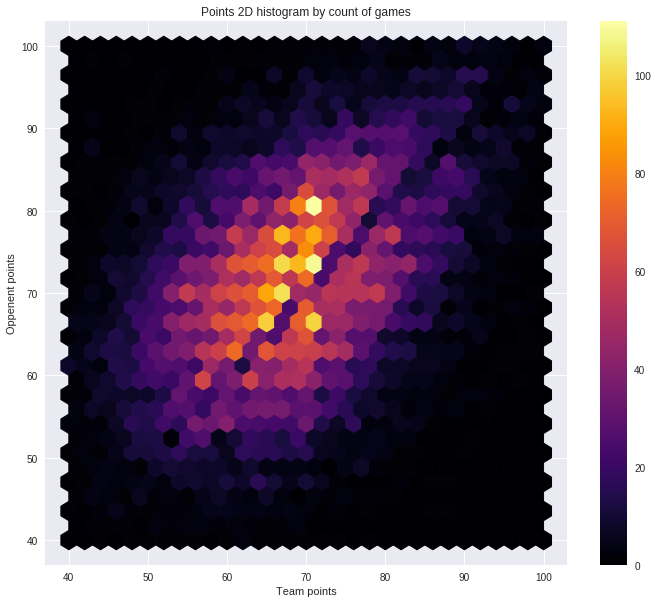

In [10]:
pl.figure(figsize=[11.7,10])
hb = pl.hexbin(df['points'], df['opponent_points'], gridsize=30, cmap='inferno', extent=[40, 100, 40, 100])
pl.xlabel('Team points')
pl.ylabel('Oppenent points')
pl.title('Points 2D histogram by count of games')
pl.colorbar()
pl.show()

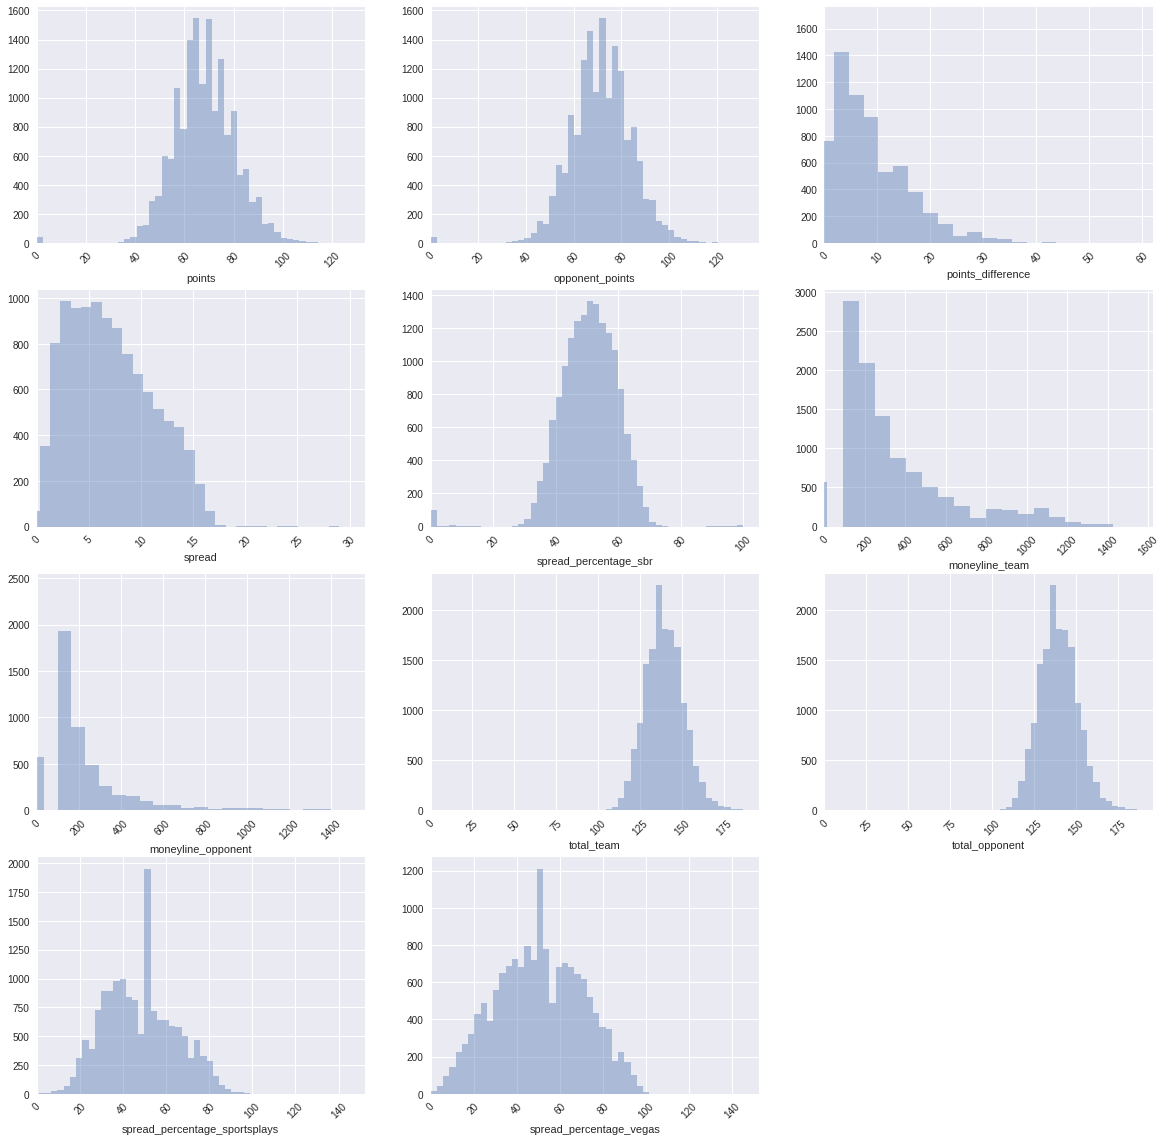

In [11]:
for i, f in enumerate(features):
    plt.subplot(4, 3,i+1)
    fig = plt.gcf()
    fig.set_size_inches(20,20)
    sns.distplot(df[f], kde=False)
    plt.xlim(0)
    plt.xticks(rotation=45)
plt.show()

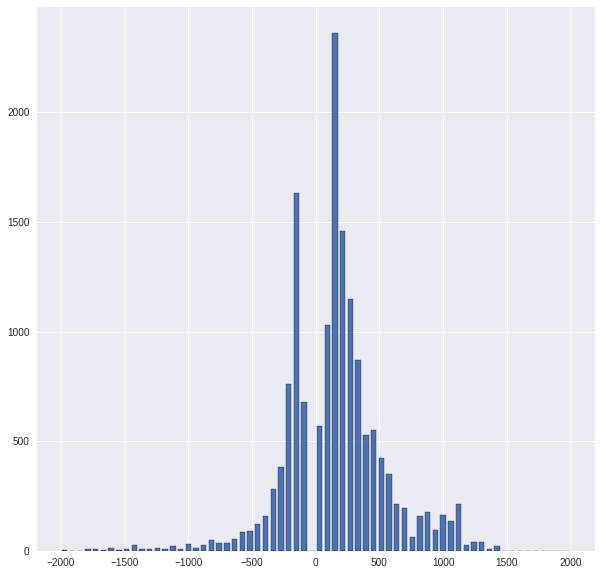

In [12]:
pts_diff = np.array(df['moneyline_team'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=66, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

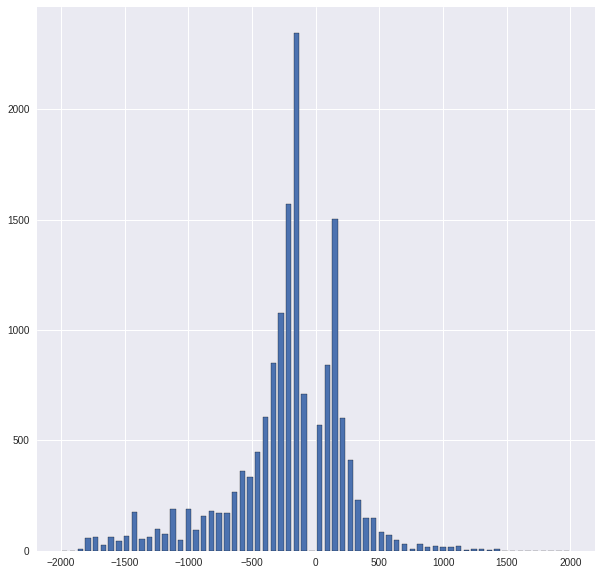

In [13]:
pts_diff = np.array(df['moneyline_opponent'])
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=66, edgecolor='black', rwidth=0.7, range=(-2000, 2000))
pl.grid(True)
pl.show()

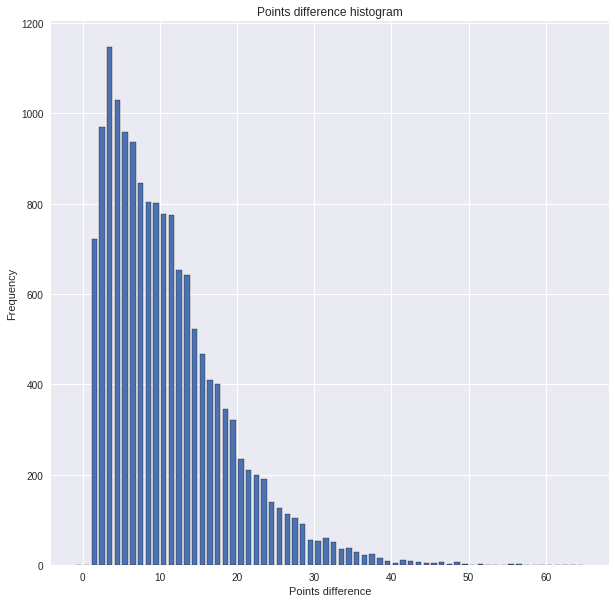

In [14]:
pts_diff = np.array(df['points_difference'])
pts_diff = np.abs(pts_diff)[pts_diff!=0]
pl.figure(figsize=[10,10])
n, bins, patches = pl.hist(pts_diff, bins=66, edgecolor='black', range=(-1, 65), rwidth=0.7)
pl.title('Points difference histogram')
pl.xlabel('Points difference')
pl.ylabel('Frequency')
# pl.xticks(range(-70,70,2))
pl.grid(True)
pl.show()

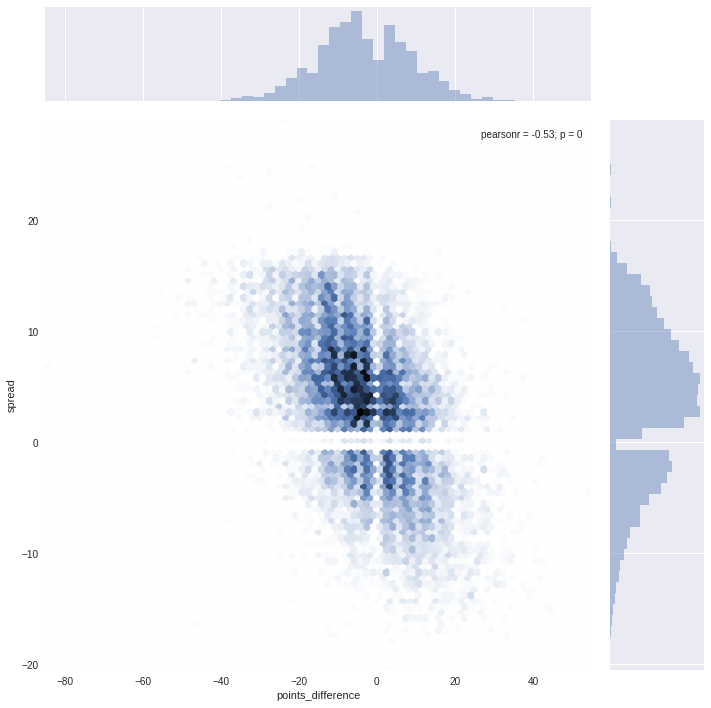

In [15]:
x = df.points_difference
y = df.spread
sns.jointplot(x=x, y=y, kind='hex', size=10)
pl.show()

# Get most similiar games

In [16]:
distance_features = ['spread', 'spread_percentage_sbr', 'moneyline_team',\
       'moneyline_opponent', 'total_team', 'total_opponent',\
       'spread_percentage_sportsplays', 'spread_percentage_vegas']

Get top 10 closest games to given game by all distance_features (using Eucleadean metric).

In [17]:
def get_similar_games(games, top=1000):
    dists = pairwise_distances(games)
    result = []
    for d in dists:
        args = d.argsort()
        similar_games = df.iloc[args[:top]]
        similar_games.insert(0, 'distance', d[args[:top]])
        result.append(similar_games)
    return result

In [18]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(np.array(df[distance_features].values))
similar_games = get_similar_games(scaled_features)

The first game is a game with a minimum distance of 0, i.e. the game itself, for which we are looking for similar games.

First selected game of 2017 NCAA Basketball season.

In [19]:
def get_crossval_score(year=2017, top=30):
    games = []
    for game in similar_games:
        if game.iloc[0].season == year:
            games.append(game)
    pos = 0
    for game in games:
        season = game.iloc[0].season
        week = game.iloc[0].weeknum
        tmp1 = game[np.logical_and(game.season <= season,\
                                   game.weeknum <= week)]
        weighted_av = np.average(tmp1.points_difference[1:top])#, weights=tmp1.distance[1:top])
        if np.sign(weighted_av) == np.sign(tmp1.points_difference.iloc[0]):
            pos += 1
    return pos / len(games)

In [38]:
def get_report(_id):
    w_av =np.average(similar_games[_id].points_difference[1:], weights=similar_games[_id].distance[1:])
    print('Weighted average points_difference for simillar games', w_av)
    print('Average points_difference for simillar games', \
          np.average(similar_games[_id].points_difference[1:]))
    pl.figure(figsize=[10,10])
    x = df.points_difference
    y = df.spread
    pl.scatter(x, y, c='lightblue', s=5, )
    
    top = 20
    x1 = similar_games[_id].points_difference
    y1 = similar_games[_id].spread
    pl.scatter(x1[:top], y1[:top], c='red', s=10)
    plt.xlim(-50,  40)
    plt.ylim(-20, 30)
    pl.xlabel('Points difference')
    pl.ylabel('Spred')
    pl.title('Show on the scatter the nearest games to the given game of 2017 season NCAA Basketball (id {})'.format(_id))
    pl.show()
    return w_av

In [35]:
def get_confidence(_id, w_av):
    top = 75
    return sqrt(np.sum((similar_games[_id].points_difference[1:top] - w_av)**2, axis=0)  / (top - 2))

In [21]:
for year in (2015, 2016, 2017):
    for top in (10, 20, 25, 30, 50, 75, 100):
        score = get_crossval_score(year, top)
        print('Crossvall accuracy score {:.4f}, {:d} year, using top {:<3} closest games to compute result.'.\
              format(score, year, top))
    print()

Crossvall accuracy score 0.6855, 2015 year, using top 10  closest games to compute result.
Crossvall accuracy score 0.6902, 2015 year, using top 20  closest games to compute result.
Crossvall accuracy score 0.6956, 2015 year, using top 25  closest games to compute result.
Crossvall accuracy score 0.7021, 2015 year, using top 30  closest games to compute result.
Crossvall accuracy score 0.7109, 2015 year, using top 50  closest games to compute result.
Crossvall accuracy score 0.7074, 2015 year, using top 75  closest games to compute result.
Crossvall accuracy score 0.7098, 2015 year, using top 100 closest games to compute result.

Crossvall accuracy score 0.6756, 2016 year, using top 10  closest games to compute result.
Crossvall accuracy score 0.6984, 2016 year, using top 20  closest games to compute result.
Crossvall accuracy score 0.6981, 2016 year, using top 25  closest games to compute result.
Crossvall accuracy score 0.6950, 2016 year, using top 30  closest games to compute result

In [36]:
_id = 15000# np.random.randint(len(df))
similar_games[_id].iloc[:12]

,distance,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
16315,0.000000,2017,8,2,19,0,UNI,INST,59,69,-10,1.0,59,103.0,-113.0,123.0,123.0,74.0,62.0
5256,0.026371,2014,7,2,19,1,SYR,PITT,58,56,2,1.5,58,110.0,-120.0,124.0,124.0,74.0,65.0
15047,0.044837,2017,2,5,16,1,LT,ODU,75,63,12,1.0,58,100.0,-120.0,123.0,123.0,72.0,56.0
6713,0.059559,2014,49,2,23,0,WICH,UTAH,68,69,-1,3.0,58,145.0,-155.0,128.0,128.0,73.0,61.0
3456,0.068443,2013,49,2,19,1,WIS,UVA,48,38,10,4.0,58,165.0,-175.0,124.0,124.0,72.0,61.0
385,0.077008,2012,52,6,19,0,DAY,USC,61,63,-2,3.0,58,150.0,-160.0,127.0,127.0,68.0,67.0
12279,0.078186,2016,7,1,19,1,BALL,M-OH,73,56,17,-1.0,56,-119.0,-101.0,124.5,124.5,75.0,60.0
5525,0.078200,2014,8,3,19,1,TOWS,NE,79,70,9,1.0,59,102.0,-112.0,131.5,131.5,78.0,67.0
7815,0.079247,2015,4,6,14,0,FAIR,MRST,67,73,-6,1.0,56,102.0,-112.0,121.5,121.5,64.0,65.0
7532,0.080243,2015,3,5,18,1,TENN,MIZZ,59,51,8,-1.0,56,-105.0,-105.0,125.0,125.0,71.0,65.0


Weighted average points_difference for simillar games -0.624840610374
Average points_difference for simillar games -0.682682682683


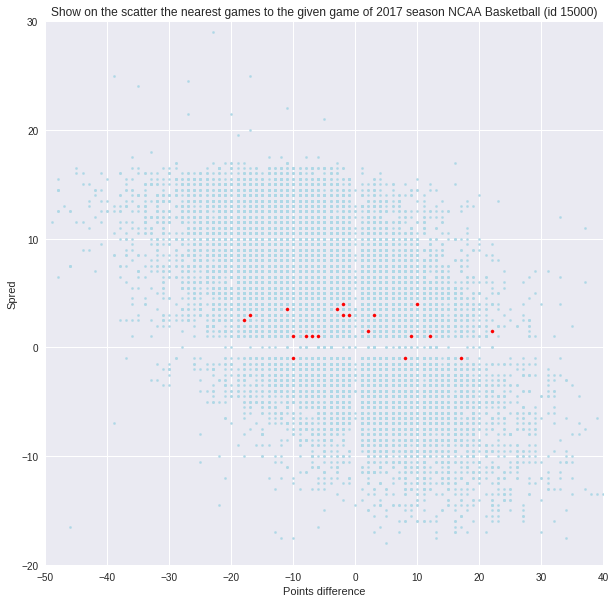

Confidence 9.99002195702


In [40]:
w_av = get_report(_id)
print('Confidence', get_confidence(_id, w_av))

Second selected game of 2017 NCAA Basketball season.

In [44]:
_id = 15250# np.random.randint(len(df))
similar_games[_id].iloc[:12]

,distance,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
16568,0.000000,2017,9,2,20,0,BC,ND,66,82,-16,15.5,52,1050.0,-1600.0,155.0,155.0,44.0,39.0
16579,0.041051,2017,9,2,22,0,WSU,USC,64,87,-23,14.5,54,1025.0,-1550.0,152.5,152.5,42.0,40.0
3005,0.061068,2013,46,4,23,0,NAU,USC,63,67,-4,16.5,53,1050.0,-1600.0,160.0,160.0,50.0,40.0
15044,0.069416,2017,2,5,18,0,MIZZ,ARK,73,92,-19,14.5,53,1000.0,-1500.0,151.5,151.5,38.0,35.0
15337,0.080438,2017,3,6,14,0,FAIR,MONM,49,91,-42,14.5,47,1000.0,-1500.0,161.0,161.0,46.0,41.0
11332,0.084381,2016,3,2,19,0,DUQ,VCU,71,93,-22,15.0,52,1050.0,-1600.0,156.0,156.0,39.0,50.0
13665,0.086273,2016,47,1,13,0,TENN,ORE,65,69,-4,14.0,49,925.0,-1400.0,154.5,154.5,43.0,35.0
3075,0.086475,2013,47,0,22,1,IDST,SF,93,90,3,15.5,50,1100.0,-1700.0,150.5,150.5,45.0,29.0
9715,0.086521,2015,47,5,13,0,COFC,DAV,81,82,-1,15.5,48,1150.0,-1450.0,154.5,154.5,43.0,31.0
15109,0.088514,2017,3,0,19,0,SYR,UNC,68,85,-17,14.5,49,1000.0,-1500.0,152.5,152.5,39.0,30.0


Weighted average points_difference for simillar games -14.352105216
Average points_difference for simillar games -14.4974974975


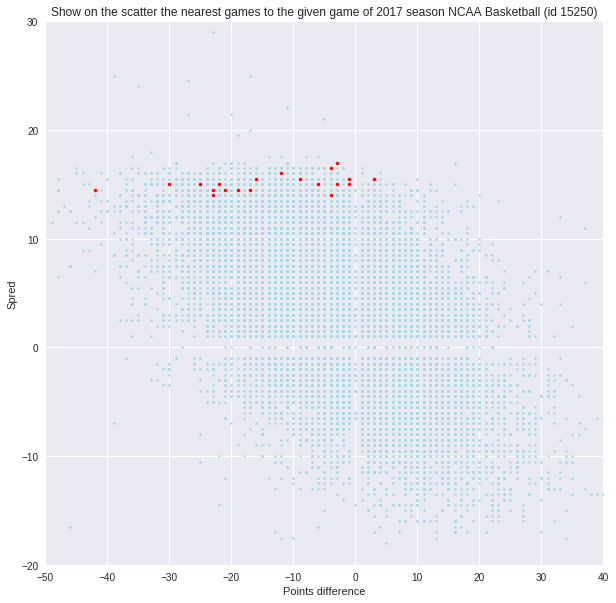

Confidence 10.2830802744


In [45]:
w_av = get_report(_id)
print('Confidence', get_confidence(_id, w_av))

Third selected game of 2017 NCAA Basketball season.

In [48]:
_id = 15300# np.random.randint(len(df))
similar_games[_id].iloc[:12]

,distance,season,weeknum,weekday,hour,winlose,team,opponent_team,points,opponent_points,points_difference,spread,spread_percentage_sbr,moneyline_team,moneyline_opponent,total_team,total_opponent,spread_percentage_sportsplays,spread_percentage_vegas
16622,0.000000,2017,9,3,19,0,MRST,CAN,73,77,-4,9.0,41,420.0,-475.0,155.0,155.0,30.0,66.0
16158,0.057495,2017,7,4,19,1,KENT,AKR,70,67,3,8.5,43,375.0,-470.0,148.5,148.5,32.0,67.0
9134,0.066215,2015,10,5,24,0,SIE,IONA,71,74,-3,8.5,36,340.0,-380.0,156.5,156.5,28.0,64.0
15070,0.075570,2017,2,5,24,1,PEAY,EIU,92,84,8,8.0,42,295.0,-355.0,151.0,151.0,28.0,60.0
8024,0.080656,2015,5,5,15,0,TNTC,BEL,53,71,-18,9.0,45,385.0,-435.0,150.0,150.0,32.0,74.0
14322,0.081650,2016,51,0,21,0,TROY,WYO,66,72,-6,8.5,41,355.0,-400.0,153.0,153.0,34.0,56.0
14260,0.087693,2016,50,5,20,0,WAKE,XAV,65,69,-4,9.5,44,380.0,-475.0,154.0,154.0,34.0,55.0
11690,0.097255,2016,4,5,17,1,UNM,BSU,88,83,5,8.0,44,310.0,-370.0,152.5,152.5,35.0,56.0
4899,0.099617,2014,5,5,13,0,SCAR,MISS,71,75,-4,10.5,42,480.0,-570.0,151.0,151.0,29.0,54.0
16249,0.100276,2017,7,5,20,0,NIAG,SIE,70,76,-6,8.0,40,335.0,-420.0,153.5,153.5,39.0,56.0


Weighted average points_difference for simillar games -6.9269154142
Average points_difference for simillar games -6.97997997998


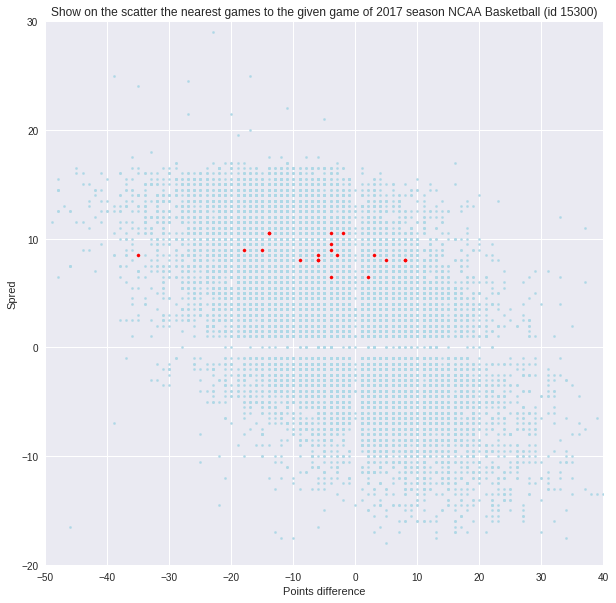

Confidence 9.87280190689


In [47]:
w_av = get_report(_id)
print('Confidence', get_confidence(_id, w_av))

## Some plots

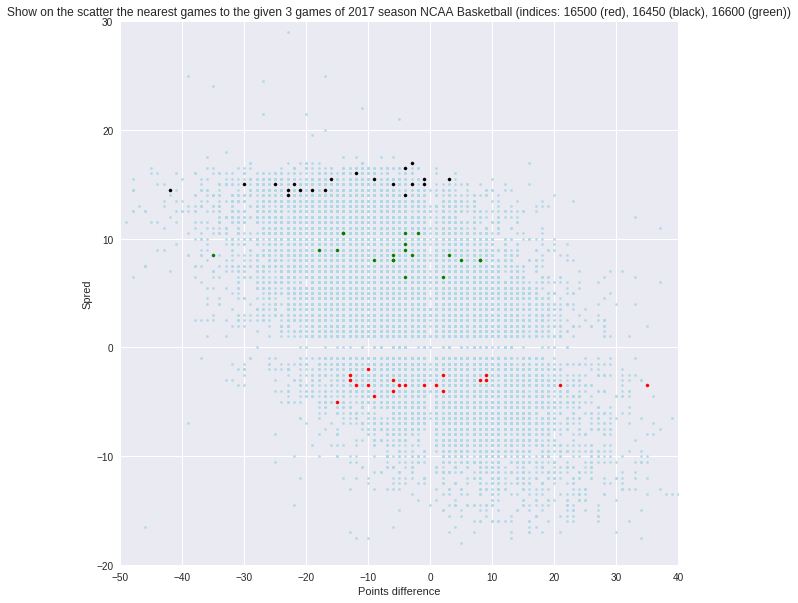

In [49]:
pl.figure(figsize=[10,10])
x = df.points_difference
y = df.spread
pl.scatter(x, y, c='lightblue', s=5, )
top = 20
x1 = similar_games[15200].points_difference
y1 = similar_games[15200].spread
pl.scatter(x1[:top], y1[:top], c='red', s=10)
x1 = similar_games[15250].points_difference
y1 = similar_games[15250].spread
pl.scatter(x1[:top], y1[:top], c='black', s=10)
x1 = similar_games[15300].points_difference
y1 = similar_games[15300].spread
pl.scatter(x1[:top], y1[:top], c='green', s=10)
plt.xlim(-50,  40)
plt.ylim(-20, 30)
pl.xlabel('Points difference')
pl.ylabel('Spred')
pl.title('Show on the scatter the nearest games to the given 3 games of 2017 season NCAA Basketball (indices: 16500 (red), 16450 (black), 16600 (green))')
pl.show()

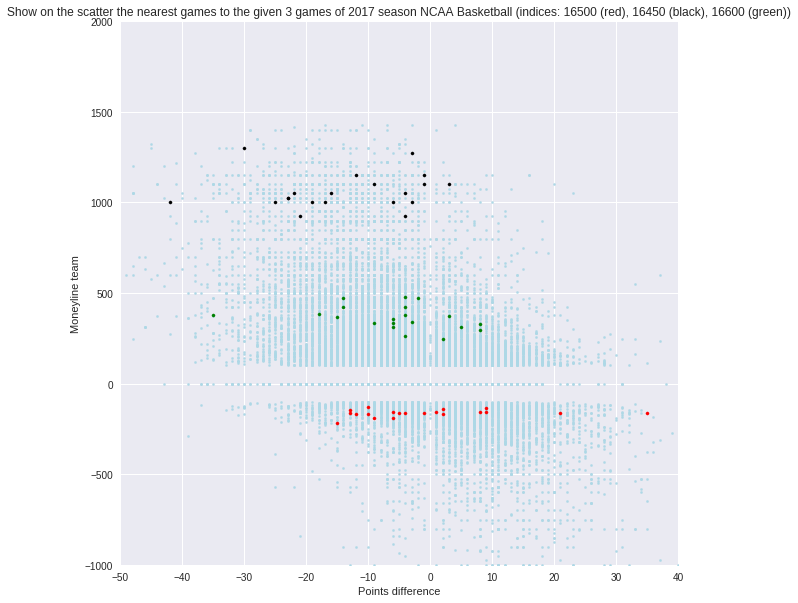

In [53]:
pl.figure(figsize=[10,10])
x = df.points_difference
y = df.moneyline_team
pl.scatter(x, y, c='lightblue', s=5, )
top = 20
x1 = similar_games[15200].points_difference
y1 = similar_games[15200].moneyline_team
pl.scatter(x1[:top], y1[:top], c='red', s=10)
x1 = similar_games[15250].points_difference
y1 = similar_games[15250].moneyline_team
pl.scatter(x1[:top], y1[:top], c='black', s=10)
x1 = similar_games[15300].points_difference
y1 = similar_games[15300].moneyline_team
pl.scatter(x1[:top], y1[:top], c='green', s=10)
plt.xlim(-50,  40)
plt.ylim(-1000, 2000)
pl.xlabel('Points difference')
pl.ylabel('Moneyline team')
pl.title('Show on the scatter the nearest games to the given 3 games of 2017 season NCAA Basketball (indices: 16500 (red), 16450 (black), 16600 (green))')
pl.show()

## Analysis of timeseries

In [1]:
filepath = 'seeds/ncaa_movement.csv'

In [156]:
df_raw = pd.read_csv(filepath)
df = df_raw.drop(['team_org', 'opponent_team_org'], axis=1)
vals = []
df.head()

,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:42,-106.5,96.5
4,pinnacle,20120101,12:00p,RUTG,USF,1/1/2017 11:42,-104.5,-105.5


In [157]:
#add 24-hour formatted time
new_times = []
for i in df.time:
    if i[-1] == 'a':
        spl = i.split(':')
        h = spl[0]
        m = spl[1][:-1]
        tmp = 12+int(h)
        hour = '00' if tmp == 24 else tmp
        s = str(hour) + ':' + m
        new_times.append(s)
    else:
        new_times.append(i[:-1])
        
df['time'] = new_times
df.head()

,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:42,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1/1/2017 11:42,-104.5,-105.5


In [158]:
#correct data_datetmie column (invalid year)
new_data_datetime = []
for d, data in zip(df.date, df.data_datetime):
    year = str(d)[:4]
    pos = data.find('2017')
    if pos == -1:
        pos = data.find('2029')
    new_date = data[:pos] + year + data[pos+4:]
    new_data_datetime.append(new_date)
df['data_datetime'] = new_data_datetime
df.head()


,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 12:01,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:44,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:43,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:42,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1/1/2012 11:42,-104.5,-105.5


In [159]:
#correct data_datetime
timestamps = []
for i in df.data_datetime:
    timestamps.append(int(datetime.strptime(i, '%m/%d/%Y %H:%M').timestamp()))
df['data_datetime'] = timestamps
df.head()


,casino,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,20120101,12:00,RUTG,USF,1325404860,-98.5,-111.5
1,pinnacle,20120101,12:00,RUTG,USF,1325403840,-101.5,-108.5
2,pinnacle,20120101,12:00,RUTG,USF,1325403780,-100.5,-109.5
3,pinnacle,20120101,12:00,RUTG,USF,1325403720,-106.5,96.5
4,pinnacle,20120101,12:00,RUTG,USF,1325403720,-104.5,-105.5


In [160]:
#date + time = timestamp
timestamps = []
for d, t in zip(df.date, df.time):
    s = str(d) + ' ' + t
    tmp = int(datetime.strptime(s, '%Y%m%d %H:%M').timestamp())
    timestamps.append(tmp)
df.insert(1, 'timestamp', timestamps)
df.head()

,casino,timestamp,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325404860,-98.5,-111.5
1,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403840,-101.5,-108.5
2,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403780,-100.5,-109.5
3,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-106.5,96.5
4,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-104.5,-105.5


In [161]:
df.head()

,casino,timestamp,date,time,team,opponent_team,data_datetime,spread_team,spread_opponent
0,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325404860,-98.5,-111.5
1,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403840,-101.5,-108.5
2,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403780,-100.5,-109.5
3,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-106.5,96.5
4,pinnacle,1325404800,20120101,12:00,RUTG,USF,1325403720,-104.5,-105.5


In [162]:
#correct spred (errors like: "PK +115" or "+5 -114")
spread_team = []
for i in df['spread_team']:
    a = float(i.split()[-1])
    spread_team.append(a)
df['spread_team'] = spread_team

spread_opponent = []
for i in df['spread_opponent']:
    a = float(i.split()[-1])
    spread_team.append(a)
df['spread_opponent'] = spread_opponent

KeyError: 'spread_opponent'

In [ ]:
books = set(df.casino)
print('Set of casinos:', books)